In [ ]:
!pip install bagpy

In [ ]:
# Switch the TensorFlow version 2.1
# !pip install tensorflow==2.1.0

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import bagpy
from bagpy import bagreader
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')
b = bagreader('/content/drive/MyDrive/Colab Notebooks/good_bag_data/my_data/sync_data_2021-12-16-10-18-50.bag')
t = bagreader('/content/drive/MyDrive/Colab Notebooks/good_bag_data/my_data/sync_data_2021-12-16-10-18-18.bag')

Mounted at /content/drive/
[INFO]  Data folder /content/drive/MyDrive/Colab Notebooks/good_bag_data/my_data/sync_data_2021-12-16-10-18-50 already exists. Not creating.
[INFO]  Data folder /content/drive/MyDrive/Colab Notebooks/good_bag_data/my_data/sync_data_2021-12-16-10-18-18 already exists. Not creating.


In [ ]:
# read from bag
visual_MSG_training = b.message_by_topic('/detecting_point_sync')
joint_MSG_training = b.message_by_topic('/joint_state_sync')
visual_MSG_testing = t.message_by_topic('/detecting_point_sync')
joint_MSG_testing = t.message_by_topic('/joint_state_sync')
# store to dataframe 
df_visual_point_training = pd.read_csv(visual_MSG_training)
df_joint_var_training = pd.read_csv(joint_MSG_training)
df_visual_point_testing = pd.read_csv(visual_MSG_testing)
df_joint_var_testing= pd.read_csv(joint_MSG_testing)
# dataframe to list
list_visual_point_training = df_visual_point_training['data_0'].tolist()
list_joint_training = df_joint_var_training['data_1'].tolist()
list_visual_point_testing = df_visual_point_testing['data_0'].tolist()
list_joint_testing = df_joint_var_testing['data_1'].tolist()

# joint_MSG = b.message_by_topic('/joint_states_from_arduino_1')

In [ ]:
print('visual point training list len:', len(list_visual_point_training))
print('joint data training list len:', len(list_joint_training))

print('visual point testing list len:', len(list_visual_point_testing))
print('joint data testing list len:', len(list_joint_testing))

visual point training list len: 390
joint data training list len: 390
visual point testing list len: 391
joint data testing list len: 391


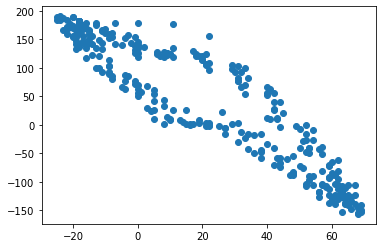

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(list_joint_training, list_visual_point_training)

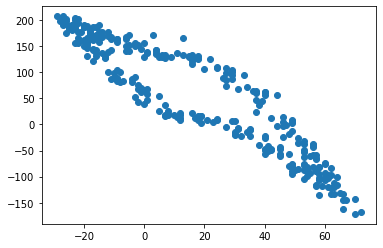

In [ ]:
plt.scatter(list_joint_testing, list_visual_point_testing)

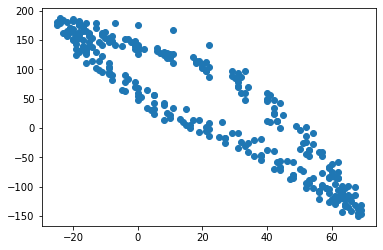

In [ ]:
from scipy.ndimage import gaussian_filter1d
list_visual_point_training_filter = gaussian_filter1d(list_visual_point_training, 1)
list_visual_point_testing_filter = gaussian_filter1d(list_visual_point_testing, 1)

plt.scatter(list_joint_training, list_visual_point_training_filter)

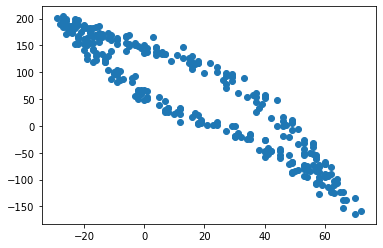

In [ ]:
plt.scatter(list_joint_testing, list_visual_point_testing_filter)

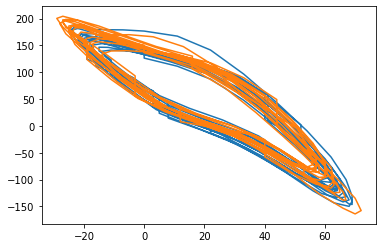

In [ ]:
plt.plot(list_joint_training, list_visual_point_training_filter)
plt.plot(list_joint_testing, list_visual_point_testing_filter)

# Let's Start to the Training progress

Create the training dataset

In [ ]:
import numpy as np

In [ ]:
# Method 0

delta = 0.05    #constant for sub_hys_model, to prevent zero in denominator

training_input_x = np.array(list_joint_training)
training_input_x = training_input_x + 50
training_input_y = np.array(list_visual_point_training_filter) +150
sub_hys_model = training_input_y/(training_input_x + np.random.normal(.01, .05, training_input_x.shape))


training_input_data_array = np.vstack((np.vstack((training_input_x, sub_hys_model)), training_input_y)).T

buff_list_visual_point_training_filter = list_visual_point_training_filter.tolist()
buff_list_visual_point_training_filter.pop()
buff_list_visual_point_training_filter = [0] + buff_list_visual_point_training_filter
# buff_list_visual_point_training_filter.pop()
# buff_list_visual_point_training_filter.pop()
# buff_list_visual_point_training_filter.pop()
# buff_list_visual_point_training_filter = [0, 0, 0, 0] + buff_list_visual_point_training_filter
training_output_data = np.array(buff_list_visual_point_training_filter)


In [ ]:
print(training_input_data_array[30])

[ 39.           7.47402589 291.29941887]


In [ ]:
# Method 1

def create_dataset(joint_list, visual_list, x_offset = 50, y_offset = 150):
  # data_initializtion
  joint_np = np.array(joint_list)
  joint_np = joint_np + x_offset
  visual_np = np.array(visual_list)
  visual_np = visual_np + y_offset
  sub_hys_model = visual_np+(joint_np + np.random.normal(.01, .05, joint_np.shape))

  # creation of future/past/current datapoints
  model_input = []
  model_output = []
  visual_future = []
  past_steps = 5
  future_steps = 5
  for i in range(len(visual_list) - future_steps - past_steps):
    # the current x
    x_current = joint_np[i + past_steps]
    # the current y
    y_current = visual_np[i + past_steps]
    # the past y (past 4 points)
    y_past = []
    for k in range(4):
      y_past.append(visual_np[i+k])
    # the future y (temp variable)
    y_future = visual_np[i + past_steps + future_steps]

    # the diff btw future and current y
    y_delta = y_future - y_current

    # the future x 
    x_future = joint_np[i + past_steps + future_steps]

    # the input set
    model_input_element = [x_current, y_current, y_delta] + [x for x in y_past]

    # the output set
    model_outpu_element = x_future

    model_input.append(model_input_element)
    model_output.append(model_outpu_element)
    visual_future.append(y_future)
  
  return model_input, model_output, visual_future
    

input_training, output_training, visual_future = create_dataset(list_joint_training, list_visual_point_training_filter)



In [ ]:
# test code
print(input_training[20])
print(output_training[20])

[55.0, 206.53720263217633, 84.76221623857975, 52.6643576182379, 92.48105953451939, 131.09039158985723, 161.07125328851953]
39.0


Create the testing dataset

In [ ]:
testing_input_x = np.array(list_joint_testing)
testing_input_x = testing_input_x + 50
testing_input_y = np.array(list_visual_point_testing_filter) +150
sub_hys_model = testing_input_y/(testing_input_x + np.random.normal(.01, .05, testing_input_x.shape))


testing_input_data_array = np.vstack((np.vstack((testing_input_x, sub_hys_model)), testing_input_y)).T

buff_list_visual_point_testing_filter = list_visual_point_testing_filter.tolist()
buff_list_visual_point_testing_filter.pop()
buff_list_visual_point_testing_filter = [0] + buff_list_visual_point_testing_filter
# buff_list_visual_point_testing_filter.pop()
# buff_list_visual_point_testing_filter.pop()
# buff_list_visual_point_testing_filter.pop()
# buff_list_visual_point_testing_filter = [0, 0, 0, 0] + buff_list_visual_point_testing_filter
testing_output_data = np.array(buff_list_visual_point_testing_filter)

**Create the model and start the training!**

In [ ]:
import tensorflow as tf
print ('TensorFlow version: ' + tf.__version__)

# Create the model 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(3,)))
model.add(tf.keras.layers.Dense(units = 4, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 4, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

# start the training
model.fit(training_input_data_array, training_output_data, epochs=200, verbose=1)

In [ ]:
# training for new NN
import tensorflow as tf
# Create the model 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(7,)))
model.add(tf.keras.layers.Dense(units = 16, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 16, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

# start the training
model.fit(input_training, output_training, epochs=200, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
12/12 [==============================] - 1s 2ms/step - loss: 1888.0529
Epoch 2/200
12/12 [==============================] - 0s 2ms/step - loss: 1359.7872
Epoch 3/200
12/12 [==============================] - 0s 2ms/step - loss: 1134.1514
Epoch 4/200
12/12 [==============================] - 0s 2ms/step - loss

# Computing the Error for the result

---



Display the predicted results and raw data

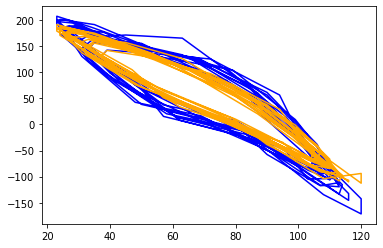

In [ ]:
# Test the model with test_data_array
y_predicted = model.predict(testing_input_data_array)

# Display the result
interval = 2
plt.plot(testing_input_x[::interval], list_visual_point_testing[::interval], c = 'blue')
plt.plot(testing_input_x[::interval], y_predicted[::interval], c = 'orange')


Compute the error for the prediction

In [ ]:
error_accu = 0
for i in range(len(y_predicted)):
  error_accu = error_accu + abs(y_predicted[i]-list_visual_point_testing_filter[i])
print(error_accu/len(y_predicted))

[10.9535475]


# Plot the figure for second method!!!

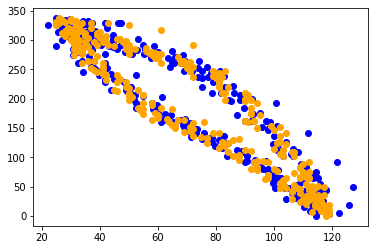

In [ ]:
# Test the model with training array and plot
q_predicted = model.predict(input_training)

plt.scatter(q_predicted[::1], visual_future[::1], c = 'blue')
plt.scatter(np.array(input_training)[:, 0], np.array(input_training)[:, 1], c = 'orange')

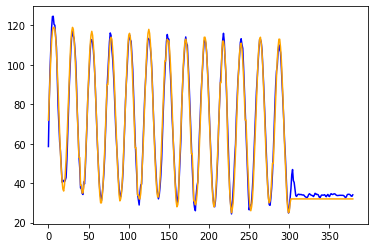

In [ ]:
plt.plot(q_predicted[::1], c = 'blue')
plt.plot(output_training, c = 'orange')


**SAVE MODEL MODEL!!**

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/NN_test.h5') 

# Experiment from Lorenzo

In [ ]:
c = bagreader('/content/drive/MyDrive/Colab Notebooks/lorenzo_results/long_data.bag')

[INFO]  Data folder /content/drive/MyDrive/Colab Notebooks/lorenzo_results/long_data already exists. Not creating.


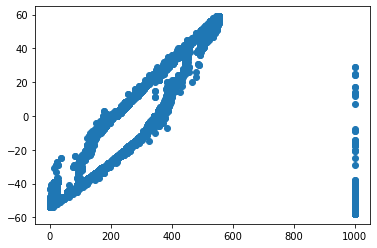

In [ ]:
error_and_data_MSG = c.message_by_topic('/error_and_data_for_error_computation_test')
df_error_and_data = pd.read_csv(error_and_data_MSG)
list_cam_x = df_error_and_data['data_2'].tolist()
list_q_1 = df_error_and_data['data_6'].tolist()
list_t_sec = df_error_and_data['data_8'].tolist()
list_t_nsec = df_error_and_data['data_9'].tolist()
import matplotlib.pyplot as plt
# plt.plot(x_new , y_new)
plt.scatter(list_cam_x, list_q_1)

In [ ]:
cam_x_official = list_cam_x
q_1_official = list_q_1
count = 0

for i in range(len(list_cam_x)-1):
  if(list_cam_x[i+1]!=1000 and (list_t_sec[i]!=list_t_sec[i+1] or list_t_nsec[i]!=list_t_nsec[i+1])):  
    cam_x_official[count]=list_cam_x[i+1]
    q_1_official[count]=list_q_1[i+1]
    count = count+1



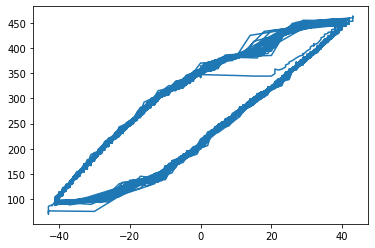

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(x_new , y_new)
plt.plot(q_1_official[:20000], cam_x_official[:20000])
q_1_official = q_1_official[:20000]
cam_x_official = cam_x_official[:20000]

In [ ]:
def split_data_set(x, y, midpoint):
  return x[:midpoint], x[midpoint:], y[:midpoint], y[midpoint:]

# split the dataset

input_x_training, input_x_testing, input_y_training, input_y_testing = split_data_set(q_1_official, cam_x_official, 15000)

15000


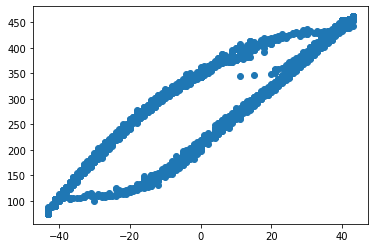

In [ ]:
from scipy.ndimage import gaussian_filter1d
input_y_training_filter = gaussian_filter1d(input_y_training, 2)
input_y_testing_filter = gaussian_filter1d(input_y_testing, 2)

plt.scatter(input_x_training, input_y_training_filter)
print(len(input_y_training_filter))

In [ ]:
import numpy as np

In [ ]:
# to build input for model
import numpy as np
def create_nn_input_array(input_x, input_y):
  # for training input
  offset_x = 70
  offset_y = 0
  offset_time = 2
  input_x = np.array(input_x)
  input_x = input_x + offset_x
  input_y = np.array(input_y)
  sub_hys_model = input_y/(input_x + np.random.normal(.01, .05, input_x.shape))
  model_input_array = np.vstack((np.vstack((input_x, sub_hys_model)), input_y)).T
  
  # for training output
  buff_input_y = input_y.tolist()
  for i in range(offset_time):
    buff_input_y.pop()
  buff_input_y = [0] * offset_time + buff_input_y
  model_ouput_array = np.array(buff_input_y)

  return model_input_array, model_ouput_array

training_input, training_output = create_nn_input_array(input_x_training, input_y_training_filter)
testing_input, testing_ouput = create_nn_input_array(input_x_testing, input_y_testing_filter)


In [ ]:
import numpy as np
delta = 0.05    #constant for sub_hys_model, to prevent zero in denominator

training_input_x = np.array(q_1_official)
training_input_x = training_input_x  + 70
training_input_y = np.array(cam_x_official_filter)
sub_hys_model = training_input_y/(training_input_x + np.random.normal(.01, .05, training_input_x.shape))
# sub_hys_model = training_input_x/(training_input_y + np.random.normal(.01, .05, training_input_x.shape))


training_input_data_array = np.vstack((np.vstack((training_input_x, sub_hys_model)), training_input_y)).T

buff_cam_x_official_filter = cam_x_official_filter.tolist()
buff_cam_x_official_filter.pop()
buff_cam_x_official_filter.pop()
buff_cam_x_official_filter.pop()
buff_cam_x_official_filter.pop()
buff_cam_x_official_filter = [0, 0, 0, 0] + buff_cam_x_official_filter
training_output_data = np.array(buff_cam_x_official_filter)


In [ ]:
import tensorflow as tf

# Create the model 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(3,)))
model.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 8, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'linear'))
model.compile(loss='mse', optimizer="adam")

# Display the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 32        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(training_input, training_output, epochs=5, verbose=1)

Epoch 1/5
469/469 [==============================] - 1s 1ms/step - loss: 8709.1719
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 77.0044
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 75.9693
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 74.5337
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 72.7399


5000 5000


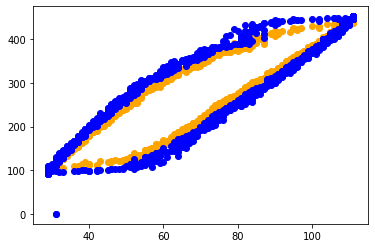

In [ ]:
# Compute the output 
output_predicted = model.predict(testing_input)
print(len(testing_input), len(output_predicted))
# Display the result
plt.scatter(testing_input.T[0], output_predicted, c = 'orange')
plt.scatter(testing_input.T[0], testing_ouput, c = 'blue')


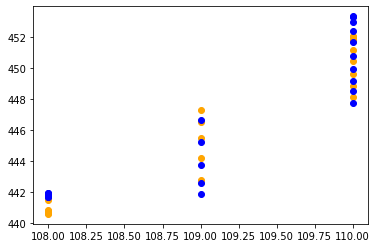

In [ ]:
output_predicted_training = model.predict(training_input)

plt.scatter(training_input.T[0][200:220], output_predicted_training[200:220], c = 'orange')
plt.scatter(training_input.T[0][200:220], training_output[200:220], c = 'blue')

In [ ]:
# def pop_out_points(a, b, threshold=999):
  
#   if len(a)>len(b):
#     diff = len(a) - len(b)
#     interval = len(a) / diff
#     for i in range(diff):
#       a.pop(diff * i)
#   elif len(a)<len(b):
#     diff = len(b) - len(a)
#     interval = len(b) / diff
#     for i in range(diff):
#       b.pop(diff * (i+1))


#   new_a = [x for x, y in zip(a, b) if y < threshold]
#   new_b = [y for x, y in zip(a, b) if y < threshold]

#   return new_a, new_b

In [ ]:
# def pop_out_points(a, b, threshold=999):
#   if len(a)>len(b):
#     a = a[0:len(b)]
#   elif len(a)<len(b):
#     b = b[0:len(a)]
#   else:
#     None
#   new_a = [x for x, y in zip(a, b) if y < threshold]
#   new_b = [y for x, y in zip(a, b) if y < threshold]
  
#   return new_a, new_b
    

In [ ]:
# list_joint_training ,list_visual_point_training = pop_out_points(list_joint_training, list_visual_point_training)
